<a href="https://colab.research.google.com/github/Arun-nexus/deep_learning/blob/main/news_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv(r"C:\Users\Arun\Downloads\Data_Train.csv\Data_Train.csv",encoding="latin_1")
df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ...",1
4,"In global markets, gold prices edged up today ...",3


In [ ]:
from nltk.corpus import stopwords
x=df["STORY"].tolist()
y=df["SECTION"]

In [ ]:
import nltk
from nltk import word_tokenize,WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def preprocess(text):
    token=[word_tokenize(row.lower()) for row in text]
    text=[lemmatizer.lemmatize(word) for row in token for word in row]

    return text
tokens=preprocess(x)

In [ ]:
from collections import Counter
words=Counter(tokens)

In [ ]:
dict={"<pad>":0,"<unk>":1}
for vocab in words:
    dict[vocab]=len(dict)


In [ ]:
vocab_size=len(dict)
sequence =[]
rows=[]
for row in x:
    words=row.split()
    index=[dict.get(word,dict['<unk>']) for word in words]
    sequence.append(index)




In [ ]:
import torch
sequence=[torch.tensor(seq) for seq in sequence]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
data=pad_sequence(sequence,batch_first=True,padding_value=dict['<pad>'])

In [ ]:
data.shape
data=data[:,:200]

In [ ]:
data.shape
y=torch.tensor(y)
from torch.utils.data import TensorDataset, DataLoader
dataset=TensorDataset(data,y)

In [ ]:
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(dataset,test_size=0.3,random_state=42)
train_data_loader=DataLoader(train_data,batch_size=128)
val_data_loader=DataLoader(val_data,batch_size=128)

In [ ]:
import torch.nn as nn
class early_stopping(nn.Module):
    def __init__(self,min_delta,patience):
        super().__init__()
        self.min_delta=min_delta
        self.partience=patience
        self.early_stop=False
        self.best_loss=float("inf")
        self.counter=0

    def __call__(self,val_loss):
        if self.min_delta >= val_loss-self.best_loss:
            self.counter=0
            self.best_loss=val_loss
        else:
            self.counter+=1
            if self.counter>=self.partience:
                self.early_stop=True

In [ ]:
import math
class positional_encoding(nn.Module):
    def __init__(self,d_model,max_len=100):
        super().__init__()
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        pe=pe.unsqueeze(0)
        self.register_buffer("pe",pe)

    def forward(self,x):
        return x+self.pe[:,:x.size(1)]

In [ ]:
class multihead_attention(nn.Module):
    def __init__(self,d_model,num_heads):
        super().__init__()
        assert d_model%num_heads==0

        self.d_k=d_model//num_heads
        self.num_heads=num_heads
        self.q_lin=nn.Linear(d_model,d_model)
        self.k_lin=nn.Linear(d_model,d_model)
        self.v_lin=nn.Linear(d_model,d_model)
        self.out=nn.Linear(d_model,d_model)

    def forward(self,q,k,v,mask=None):
        batch_size=q.size(0)
        def transform(x,linear):
            x=linear(x)
            x=x.view(batch_size,-1,self.num_heads,self.d_k)
            return x.transpose(1,2)
        q,k,v=transform(q,self.q_lin),transform(k,self.k_lin),transform(v,self.v_lin)
        scores=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(self.d_k)
        if mask is not None:
            scores=scores.masked_fill(mask==0,-1e9)
        attn=torch.softmax(scores,dim=-1)
        output=torch.matmul(attn,v)
        output=output.transpose(1,2).contiguous().view(batch_size,-1,self.d_k*self.num_heads)
        return self.out(output)

In [ ]:
class feedforward(nn.Module):
    def __init__(self,d_model,d_ff=2048,drop=0.2):
        super().__init__()
        self.feature=nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.Dropout(drop),
            nn.Linear(d_ff,d_model)
        )
    def forward(self,x):
        return self.feature(x)


In [ ]:
class trasnformerencoder(nn.Module):
    def __init__(self,d_model,num_heads,d_ff,drop=0.2):
        super().__init__()
        self.attn=multihead_attention(d_model,num_heads)
        self.ff=feedforward(d_model,d_ff,drop)
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.dropout=nn.Dropout(drop)

    def forward(self,x,mask=None):
        x2=self.norm1(x+self.dropout(self.attn(x,x,x,mask)))
        x3=self.ff(x2)
        x=self.norm2(x2+self.dropout(self.attn(x3,x3,x3,mask)))
        return x

In [ ]:
class encoder(nn.Module):
    def __init__(self,vocab_size,d_model,max_len,num_layers,num_heads,d_ff,num_classes):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,d_model)
        self.pe=positional_encoding(d_model,max_len)
        self.layer=nn.ModuleList(trasnformerencoder(d_model,num_heads,d_ff,0.2) for _ in range(num_layers))
        self.norm=nn.LayerNorm(d_model)
        self.fc=nn.Linear(d_model,num_classes)

    def forward(self,src,mask=None):
        x=self.embedding(src)
        x=self.pe(x)
        for layer in self.layer:
            x=layer(x,mask)
            x= self.norm(x)
            x=x.mean(dim=1)
            return self.fc(x)

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
model=encoder(vocab_size=vocab_size,d_model=512,max_len=200,num_layers=6,num_heads=8,d_ff=2048,num_classes=len(set(y.tolist()))).to(device)
model_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=2)

In [ ]:
from torch.amp import GradScaler,autocast

In [ ]:
epochs=50
stopper=early_stopping(1e-4,4)
training_loss_store=[]
validation_loss_store=[]
training_accuracy_store=[]
validation_accuracy_store=[]
scaler=GradScaler()

for epoch in range(epochs):
    running,total,correct=0,0,0
    for x,y in train_data_loader:
        x,y=x.to(device),y.to(device)

        optimizer.zero_grad()
        with autocast("cuda"):
            output=model(x)
            loss=model_loss(output,y)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running+=loss.item()
        _,pred=torch.max(output,1)
        correct+=(pred==y).sum().item()
        total+=y.size(0)
        # print(torch.isnan(pred).any(), torch.isnan(y).any())

    training_loss=running/len(y)
    training_acc=correct/total
    training_loss_store.append(training_loss)
    training_accuracy_store.append(training_acc)

    model.eval()
    vrunning,vtotal,vcorrect=0,0,0
    for x,y in val_data_loader:
        x,y=x.to(device),y.to(device)

        optimizer.zero_grad()
        with autocast("cuda"):
            voutput=model(x)
            vloss=model_loss(voutput,y)

        vrunning+=vloss.item()
        _,vpred=torch.max(voutput,1)
        vcorrect+=(vpred==y).sum().item()
        vtotal+=y.size(0)
    val_loss=vrunning/len(y)
    val_acc=vcorrect/vtotal
    validation_loss_store.append(val_loss)
    validation_accuracy_store.append(val_acc)

    print(f"epoch: {epoch+1} training_loss: {training_loss:.4f} training acc:{training_acc:.2f} validation_loss: {val_loss:.4f} validation_acc: {val_acc:.2f} ")
    stopper(val_loss)
    if stopper.early_stop:
        print("early_stopping triggered")
        break

epoch: 1 training_loss: 0.5745 training acc:0.43 validation_loss: 0.1923 validation_acc: 0.47 
epoch: 2 training_loss: 0.5589 training acc:0.47 validation_loss: 0.1895 validation_acc: 0.48 
epoch: 3 training_loss: 0.5518 training acc:0.48 validation_loss: 0.1871 validation_acc: 0.50 
epoch: 4 training_loss: 0.5413 training acc:0.50 validation_loss: 0.1831 validation_acc: 0.51 
epoch: 5 training_loss: 0.5242 training acc:0.52 validation_loss: 0.1772 validation_acc: 0.53 
epoch: 6 training_loss: 0.4957 training acc:0.56 validation_loss: 0.1624 validation_acc: 0.59 
epoch: 7 training_loss: 0.4238 training acc:0.63 validation_loss: 0.1319 validation_acc: 0.67 
epoch: 8 training_loss: 0.3447 training acc:0.71 validation_loss: 0.1147 validation_acc: 0.71 
epoch: 9 training_loss: 0.2894 training acc:0.76 validation_loss: 0.1002 validation_acc: 0.75 
epoch: 10 training_loss: 0.2523 training acc:0.80 validation_loss: 0.0900 validation_acc: 0.78 
epoch: 11 training_loss: 0.2231 training acc:0.82

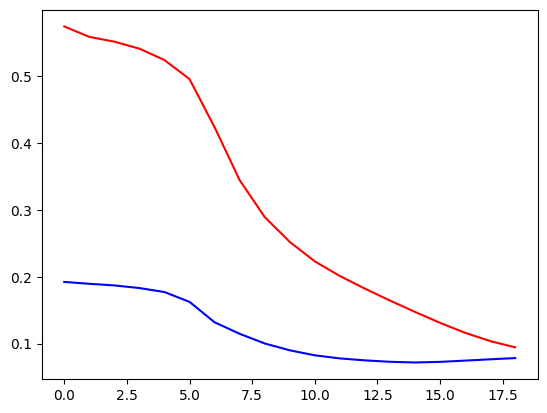

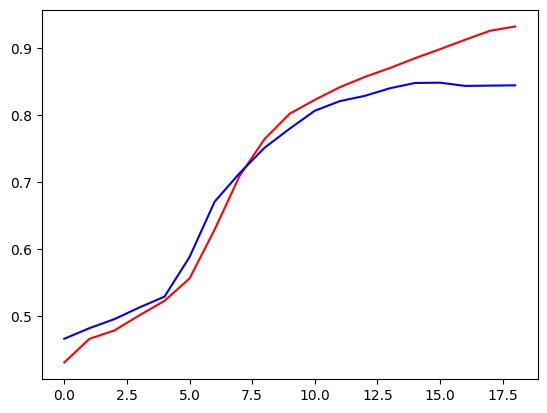

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss_store,color="red")
plt.plot(validation_loss_store,color="blue")
plt.show()
plt.plot(training_accuracy_store,color="red")
plt.plot(validation_accuracy_store,color="blue")
plt.show()

In [ ]:
new_data="Most Asian currencies were trading lower today."
max_len=200
process_data=preprocess(new_data)
new_sequence = [dict.get(word, dict['<unk>']) for word in new_data.split()]
if len(new_sequence) < max_len:
    new_sequence += [dict['<pad>']] * (max_len - len(new_sequence))
else:
    new_sequence = new_sequence[:max_len]

input_tensor = torch.tensor(new_sequence).unsqueeze(0).to(device)
output = model(input_tensor)
pred = torch.argmax(output, dim=1)
print(pred)

tensor([3], device='cuda:0')
